In [1]:
#disable some annoying warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve, StratifiedKFold
from sklearn.metrics import mean_squared_error, hamming_loss, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier

from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.neural_network import MLPClassifier

pd.set_option('display.max_columns', None)  

# Functions

In [2]:
def classify(_valence, _arousal):
    quadrants_pred = list()
    
    for i in range(len(_valence)):
        valence = _valence[i]
        arousal = _arousal[i]
        
        if valence >= 0. and arousal > 3.0:
            quadrants_pred.append(1.)

        if valence > 0 and arousal <= 3.0:
            quadrants_pred.append(4.)

        if valence < 0. and arousal >= 3.0:
            quadrants_pred.append(2.)

        if valence <= 0 and arousal < 3.0:
            quadrants_pred.append(3.)
        
        """
        lock = False
                
        if valence < 0 and not lock:
            quadrants_pred.append(1.)
            lock = True

        if valence >= 0 and not lock:
            quadrants_pred.append(2.)
            lock = True

        if arousal < 3 and not lock:
            quadrants_pred.append(3.)
            lock = True

        if arousal >= 3 and not lock:
            quadrants_pred.append(4.)
            lock = True
        """
    
    return np.array(quadrants_pred)

def profit(confusion):
    cost = np.array([
        [5., -5., -5., 2.],
        [-5., 10., 2., -5.],
        [-5., 2., 10., -5.],
        [2., -5., -2., 5.]
    ])
    
    return (confusion * cost).sum()

In [3]:
data = pd.read_pickle('data.pkl')
test = pd.read_csv('test.csv')

data.head()

,pianist_id,segment_id,snippet_id,essentia_dissonance_mean,essentia_dissonance_stdev,essentia_dynamic_complexity,essentia_loudness,essentia_onset_rate,essentia_pitch_salience_mean,essentia_pitch_salience_stdev,essentia_spectral_centroid_mean,essentia_spectral_centroid_stdev,essentia_spectral_complexity_mean,essentia_spectral_complexity_stdev,essentia_spectral_rolloff_mean,essentia_spectral_rolloff_stdev,essentia_strong_peak_mean,essentia_strong_peak_stdev,librosa_bpm,librosa_chroma_mean_0,librosa_chroma_std_0,librosa_chroma_pct_10_0,librosa_chroma_pct_50_0,librosa_chroma_pct_90_0,librosa_chroma_mean_1,librosa_chroma_std_1,librosa_chroma_pct_10_1,librosa_chroma_pct_50_1,librosa_chroma_pct_90_1,librosa_chroma_mean_2,librosa_chroma_std_2,librosa_chroma_pct_10_2,librosa_chroma_pct_50_2,librosa_chroma_pct_90_2,librosa_chroma_mean_3,librosa_chroma_std_3,librosa_chroma_pct_10_3,librosa_chroma_pct_50_3,librosa_chroma_pct_90_3,librosa_chroma_mean_4,librosa_chroma_std_4,librosa_chroma_pct_10_4,librosa_chroma_pct_50_4,librosa_chroma_pct_90_4,librosa_chroma_mean_5,librosa_chroma_std_5,librosa_chroma_pct_10_5,librosa_chroma_pct_50_5,librosa_chroma_pct_90_5,librosa_chroma_mean_6,librosa_chroma_std_6,librosa_chroma_pct_10_6,librosa_chroma_pct_50_6,librosa_chroma_pct_90_6,librosa_chroma_mean_7,librosa_chroma_std_7,librosa_chroma_pct_10_7,librosa_chroma_pct_50_7,librosa_chroma_pct_90_7,librosa_chroma_mean_8,librosa_chroma_std_8,librosa_chroma_pct_10_8,librosa_chroma_pct_50_8,librosa_chroma_pct_90_8,librosa_chroma_mean_9,librosa_chroma_std_9,librosa_chroma_pct_10_9,librosa_chroma_pct_50_9,librosa_chroma_pct_90_9,librosa_chroma_mean_10,librosa_chroma_std_10,librosa_chroma_pct_10,librosa_chroma_pct_50_10,librosa_chroma_pct_90_10,librosa_chroma_mean_11,librosa_chroma_std_11,librosa_chroma_pct_10_11,librosa_chroma_pct_50_11,librosa_chroma_pct_90_11,librosa_mfcc_mean_0,librosa_mfcc_std_0,librosa_mfcc_pct_10_0,librosa_mfcc_pct_50_0,librosa_mfcc_pct_90_0,librosa_mfcc_mean_1,librosa_mfcc_std_1,librosa_mfcc_pct_10_1,librosa_mfcc_pct_50_1,librosa_mfcc_pct_90_1,librosa_mfcc_mean_2,librosa_mfcc_std_2,librosa_mfcc_pct_10_2,librosa_mfcc_pct_50_2,librosa_mfcc_pct_90_2,librosa_mfcc_mean_3,librosa_mfcc_std_3,librosa_mfcc_pct_10_3,librosa_mfcc_pct_50_3,librosa_mfcc_pct_90_3,librosa_mfcc_mean_4,librosa_mfcc_std_4,librosa_mfcc_pct_10_4,librosa_mfcc_pct_50_4,librosa_mfcc_pct_90_4,librosa_mfcc_mean_5,librosa_mfcc_std_5,librosa_mfcc_pct_10_5,librosa_mfcc_pct_50_5,librosa_mfcc_pct_90_5,librosa_mfcc_mean_6,librosa_mfcc_std_6,librosa_mfcc_pct_10_6,librosa_mfcc_pct_50_6,librosa_mfcc_pct_90_6,librosa_mfcc_mean_7,librosa_mfcc_std_7,librosa_mfcc_pct_10_7,librosa_mfcc_pct_50_7,librosa_mfcc_pct_90_7,librosa_mfcc_mean_8,librosa_mfcc_std_8,librosa_mfcc_pct_10_8,librosa_mfcc_pct_50_8,librosa_mfcc_pct_90_8,librosa_mfcc_mean_9,librosa_mfcc_std_9,librosa_mfcc_pct_10_9,librosa_mfcc_pct_50_9,librosa_mfcc_pct_90_9,librosa_mfcc_mean_10,librosa_mfcc_std_10,librosa_mfcc_pct_10,librosa_mfcc_pct_50_10,librosa_mfcc_pct_90_10,librosa_mfcc_mean_11,librosa_mfcc_std_11,librosa_mfcc_pct_10_11,librosa_mfcc_pct_50_11,librosa_mfcc_pct_90_11,midlevel_features_melody,midlevel_features_articulation,midlevel_features_rhythm_complexity,midlevel_features_rhythm_stability,midlevel_features_dissonance,midlevel_features_tonal_stability,midlevel_features_minorness,mirtoolbox_brightness,mirtoolbox_crescendo,mirtoolbox_dynamics_mean,mirtoolbox_dynamics_std,mirtoolbox_dynamics_pct_10,mirtoolbox_dynamics_pct_50,mirtoolbox_dynamics_pct_90,mirtoolbox_hcdf_mean,mirtoolbox_hcdf_std,mirtoolbox_hcdf_pct_10,mirtoolbox_hcdf_pct_50,mirtoolbox_hcdf_pct_90,mirtoolbox_irregularity,mirtoolbox_keyclarity,mirtoolbox_mode,mirtoolbox_novelty_mean,mirtoolbox_novelty_std,mirtoolbox_novelty_pct_10,mirtoolbox_novelty_pct_50,mirtoolbox_novelty_pct_90,mirtoolbox_pulseclarity,mirtoolbox_roughness_mean,mirtoolbox_roughness_std,mirtoolbox_roughness_pct_10,mirtoolbox_roughness_pct_50,mirtoolbox_roughness_pct_90,quadrant,valence,arousal,ge

In [4]:
arousal_labels = data["arousal"].to_numpy().flatten()
valence_labels = data["valence"].to_numpy().flatten()
quadrants = data["quadrant"].to_numpy().flatten()

labels = [
    {
        "name": "arousal",  
        "labels": arousal_labels
    },
    {
        "name": "valence",  
        "labels": valence_labels
    }
]

piece_ids = test[["pianist_id", "segment_id", "snippet_id"]]

In [5]:
data = data.drop(columns=[
    'librosa_chroma_pct_50_1',  #keep just the most representative amonst the highly correlated
    'librosa_chroma_pct_50_3', 
    'librosa_chroma_pct_50_4', 
    'librosa_chroma_pct_50_6', 
    'librosa_chroma_pct_50_8', 
    'librosa_chroma_pct_50_9', 
    'librosa_chroma_pct_50_10', 
    # 'librosa_chroma_pct_50_11', 
    'librosa_mfcc_pct_10_0', 
    'librosa_mfcc_pct_50_0', 
    'librosa_mfcc_pct_90_0', 
    'librosa_mfcc_pct_50_1', 
    'librosa_mfcc_pct_10_2', 
    'librosa_mfcc_pct_50_2', 
    'librosa_mfcc_pct_90_2', 
    'librosa_mfcc_pct_50_3', 
    'librosa_mfcc_pct_50_4', 
    'librosa_mfcc_pct_50_5', 
    'librosa_mfcc_pct_50_6', 
    'librosa_mfcc_pct_50_7', 
    'librosa_mfcc_pct_50_8', 
    'librosa_mfcc_pct_50_9', 
    'librosa_mfcc_pct_50_10', 
    #'librosa_mfcc_pct_50_11', 
    'mirtoolbox_dynamics_pct_10', 
    'mirtoolbox_dynamics_pct_50', 
    #'mirtoolbox_dynamics_pct_90', 
    'mirtoolbox_novelty_pct_90', 
    'mirtoolbox_roughness_pct_50', 
    #'mirtoolbox_roughness_pct_90',

    'pianist_id', 'segment_id', 'snippet_id',

    "gems_wonder_binary",
    "gems_transcendence_binary",
    "gems_tenderness_binary",
    "gems_nostalgia_binary",
    "gems_peacefulness_binary",
    "gems_power_binary",
    "gems_joyful_activation_binary",
    "gems_tension_binary",
    "gems_sadness_binary",
    "gemmes_movement_binary",
    "gemmes_force_binary",
    "gemmes_interior_binary",
    "gemmes_wandering_binary",
    "gemmes_flow_binary",
    "gemmes_flow",
                    
    'gemmes_movement',
    'gemmes_force',
    'gemmes_wandering',
    'gems_sadness',
    'gems_tension',
    'gems_joyful_activation',
    'gems_transcendence',
    'gems_power',
    'gems_nostalgia',
    'gems_wonder',
    'gems_tenderness',
    'gemmes_interior',
    'gems_peacefulness',
    
    'quadrant',
    'arousal',
    'valence'
])

test = test.drop(columns=[
    'librosa_chroma_pct_50_1',  #keep just the most representative amonst the highly correlated
    'librosa_chroma_pct_50_3', 
    'librosa_chroma_pct_50_4', 
    'librosa_chroma_pct_50_6', 
    'librosa_chroma_pct_50_8', 
    'librosa_chroma_pct_50_9', 
    'librosa_chroma_pct_50_10', 
    # 'librosa_chroma_pct_50_11', 
    'librosa_mfcc_pct_10_0', 
    'librosa_mfcc_pct_50_0', 
    'librosa_mfcc_pct_90_0', 
    'librosa_mfcc_pct_50_1', 
    'librosa_mfcc_pct_10_2', 
    'librosa_mfcc_pct_50_2', 
    'librosa_mfcc_pct_90_2', 
    'librosa_mfcc_pct_50_3', 
    'librosa_mfcc_pct_50_4', 
    'librosa_mfcc_pct_50_5', 
    'librosa_mfcc_pct_50_6', 
    'librosa_mfcc_pct_50_7', 
    'librosa_mfcc_pct_50_8', 
    'librosa_mfcc_pct_50_9', 
    'librosa_mfcc_pct_50_10', 
    #'librosa_mfcc_pct_50_11', 
    'mirtoolbox_dynamics_pct_10', 
    'mirtoolbox_dynamics_pct_50', 
    #'mirtoolbox_dynamics_pct_90', 
    'mirtoolbox_novelty_pct_90', 
    'mirtoolbox_roughness_pct_50', 
    #'mirtoolbox_roughness_pct_90',
    
    'pianist_id', 'segment_id', 'snippet_id',
])

In [6]:
# featrue scaling
from sklearn.preprocessing import StandardScaler

sc_train = StandardScaler()
sc_test = StandardScaler()

data = sc_train.fit_transform(data)
test = sc_test.fit_transform(test)

In [7]:
# GridSearch
param_grid = [
    { 
        "n_estimators": [
            #  5, 
            # 20,
            # 50,
            # 100,
            200,
            # 500 # best
        ],
        "learning_rate": [
            # 15.0,
            # 5.0,
            3.0,
            # 2.0,
            1.0,
            # 0.1,
            # 0.01
        ],
        "loss": [
            # "linear",
            # "square",
            "exponential"
        ]
    }    
]

In [8]:
%%time 

models = list()

for label in labels:
    # Evalution:
    X_train, X_test, y_train, y_test = train_test_split(data, label["labels"], test_size=0.2, random_state=42, stratify=quadrants)
    # X_train = data
    # y_train = label["labels"]
    
    model_class = AdaBoostRegressor()
    
    trained_models = GridSearchCV(
        model_class,
        param_grid,
        cv=3
    ).fit(X_train, y_train)
    
    model = trained_models.best_estimator_
    
    y_pred = model.predict(X_test)
    # y_pred = model.predict(test)
    
    models.append({ "name": label["name"], "model": model, "label_test_true": y_test, "label_train_true": y_train, "label_test_pred": y_pred })
    # models.append({ "name": label["name"], "model": model, "label_test_pred": y_pred })
    
print()


CPU times: user 44.6 s, sys: 0 ns, total: 44.6 s
Wall time: 44.6 s


# Evalutaion

In [9]:
_, _, y_train_quadrants, y_test_quadrants = train_test_split(data, quadrants, test_size=0.2, random_state=42, stratify=quadrants)

In [10]:
arousal = models[0]
valence = models[1]

In [11]:
from sklearn.decomposition import FastICA
from sklearn.decomposition import KernelPCA

# somehow working
# model_train = TSNE(n_components=2, learning_rate=1000)
# model_test = TSNE(n_components=2, learning_rate=1000)

model_train = KernelPCA(n_components=1)
model_test = KernelPCA(n_components=1)

# model_train = FastICA(n_components=2)
# model_test = FastICA(n_components=2)


tsne_data_pred = np.concatenate([valence["label_test_pred"][:, np.newaxis], arousal["label_test_pred"][:, np.newaxis]], axis=1)
tsne_data_train = np.concatenate([valence["label_train_true"][:, np.newaxis], arousal["label_train_true"][:, np.newaxis]], axis=1)

downprojected_train = model_train.fit_transform(tsne_data_train)
downprojected_test = model_train.fit_transform(tsne_data_pred)

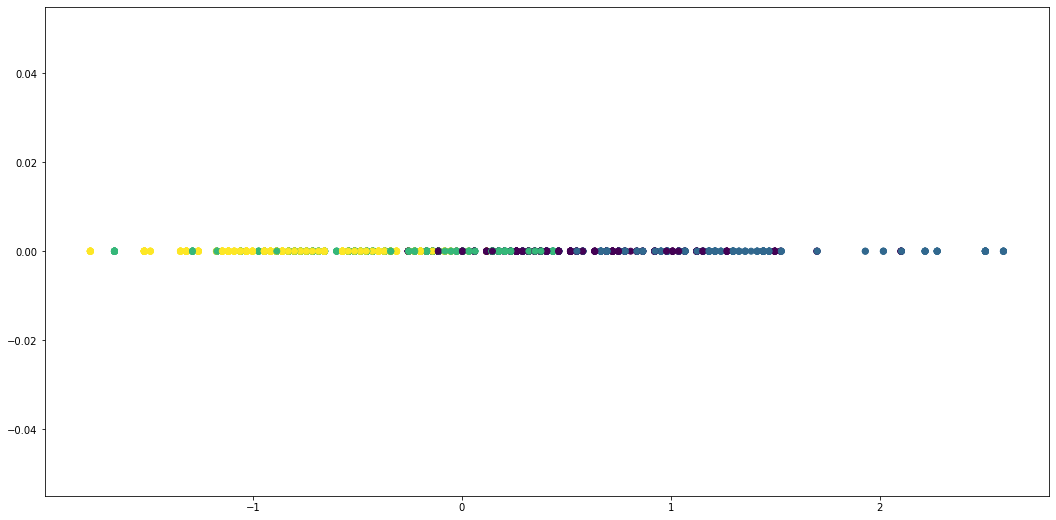

In [12]:
plt.figure(figsize=(18, 9))
plt.scatter(downprojected_train, np.zeros(len(downprojected_train)), c=y_train_quadrants)
# plt.scatter(downprojected_train[:, 0], downprojected_train[:, 1], c=y_train_quadrants)
plt.show()

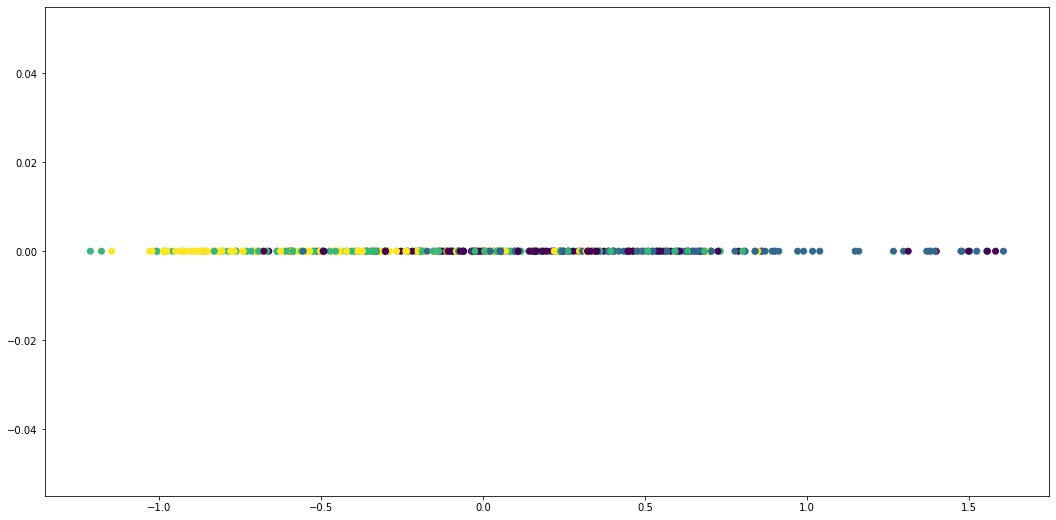

In [13]:
plt.figure(figsize=(18, 9))
plt.scatter(downprojected_test, np.zeros(len(downprojected_test)), c=y_test_quadrants)
# plt.scatter(downprojected_test[:, 0], downprojected_test[:, 1], c=y_test_quadrants)
plt.show()

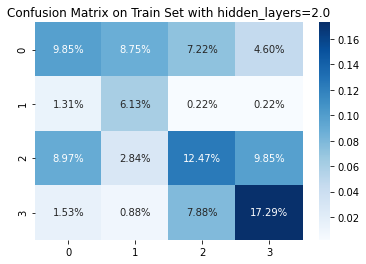

632.0
CPU times: user 173 ms, sys: 113 ms, total: 286 ms
Wall time: 144 ms


In [14]:
%%time

Cs = [
    2.0
]

for c in Cs:
    model = SVC(kernel="linear", gamma="auto", tol=0.01, C=c)
    
    X_train = downprojected_train
    y_train = y_train_quadrants
        
    model.fit(X_train, y_train)

    y_pred = model.predict(downprojected_test)
    
    confusion = confusion_matrix(y_pred, y_test_quadrants)
    sns.heatmap(confusion/confusion.sum(), annot=True, fmt='.2%', cmap='Blues').set(title=f"Confusion Matrix on Train Set with hidden_layers={c}")
    plt.show()
    print(profit(confusion))

[Text(0.5, 1.0, 'Confusion Matrix on Train Set')]

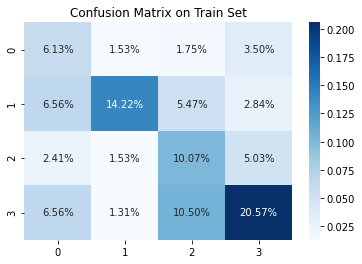

In [15]:
quadrants_pred = classify(valence["label_test_pred"], arousal["label_test_pred"])

confusion = confusion_matrix(quadrants_pred, y_test_quadrants)
sns.heatmap(confusion/confusion.sum(), annot=True, fmt='.2%', cmap='Blues').set(title="Confusion Matrix on Train Set")

In [16]:
profit(confusion)

1290.0